<a href="https://colab.research.google.com/github/mathntanzi0/HMM-and-CRF-models/blob/main/COMP703_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install hmmlearn
#!pip install sklearn-crfsuite
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import LabelEncoder
from hmmlearn import hmm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
import sklearn_crfsuite
from sklearn_crfsuite import metrics
from sklearn.preprocessing import MultiLabelBinarizer

# Dataset Pre-processing Section

In [2]:
#Getting the data
sentences = []
sentence_number = 1
with open("ss.gold.train", "r", encoding="utf-8") as file:
    next(file)
    current_sentence = []
    for line in file:
        if not line.strip():
            if current_sentence:
                sentences.append(current_sentence)
                current_sentence = []
            continue
        columns = line.strip().split("\t")
        token = columns[0]
        morph_analysis = columns[1]
        lemma = columns[2]
        #upos = columns[4]
        upos = columns[3]
        current_sentence.append((sentence_number, token, upos, morph_analysis, lemma))
        if token == '.':
            sentence_number += 1

data = []
for sentence in sentences:
    for sentence_number, token, upos, morph_analysis, lemma in sentence:
        data.append([sentence_number, token, upos, morph_analysis, lemma])

df = pd.DataFrame(data, columns=['Sentence', 'Token', 'UPOS', 'Morph_Analysis', 'Lemma'])

In [3]:
#Getting the vocabulary and tags
tags = list(set((df["UPOS"])))
vocabulary = list(set((df["Token"])))

len(tags), len(vocabulary)

(99, 14060)

In [4]:
#Spliting the data into training and testing datasets.
y = df.UPOS
X = df.drop('UPOS', axis=1)

group_spliter = GroupShuffleSplit(n_splits=2, test_size=.20, random_state=101)
train_X, test_X = next(group_spliter.split(X, y, groups=df['Sentence']))

train_data = df.loc[train_X]
test_data = df.loc[test_X]

test_data[:30]

,Sentence,Token,UPOS,Morph_Analysis,Lemma
77,5,Tindzawo,N10,tin[BPre10]-dzawo[NStem],dzawo
78,5,letingephandle,REL,leti[RelConc10]-nge[AdvPre]-phandle[Adv],phandle
79,5,:,PUNC,:[Punc],:
80,5,Leti,CDEM10,leti[Dem10][Pos1],leti
81,5,tibuya,V,ti[SC10]-buy[VRoot]-a[VerbTerm],buya
82,5,ngaphandle,ADV,nga[AdvPre]-phandle[Adv],phandle
83,5,kwamasipala,POSS15,kwa[PossConc15]-masipala[NStem],masipala
84,5,njengemali,ADV,njenga[AdvPre]-i[NPrePre4]-mali[NStem],mali
85,5,lebolekwe,REL,le[RelConc9]-bolek[VRoot]-w[PassExt]-e[VerbTerm],boleka
86,5,etigungwini,NLOC,e[LocPre]-ti[NPre8]-gungu[NStem]-ini[LocSuf],gungu


In [5]:
#Handling Unknown words.

dfunknown = train_data.sample(frac=.025, replace=False, random_state=101) #2.5% of random words in the training set.
dfunknown.Token = "<UNK>"                                                #Set the 2.5% of words to Unkown word tag.
train_data.update(dfunknown)

In [6]:
#Check of the size of vocabulary and tags in the training dataset.
tags = list(set(train_data.UPOS.values))
vocabulary = list(set(train_data.Token.values))

len(tags), len(vocabulary)

(99, 11809)

In [7]:
#Enumerating words and tags.
word_encoder = LabelEncoder()
tag_encoder = LabelEncoder()

vocabulary_encoded = word_encoder.fit_transform(vocabulary)
tags_encoded = tag_encoder.fit_transform(tags)


#print( word_encoder.transform(["kuna"])[0])
#print(word_encoder.classes_[4250])

In [8]:
#Number of occurrence of each tag.
tag_count = dict(train_data.UPOS.value_counts())

#Number of times each tag is associated to a word.
tags_to_words_count = train_data.groupby(['UPOS']).apply(lambda grp: grp.groupby('Token')['UPOS'].count().to_dict()).to_dict()

#Number of times each tag is at the start of a senctance.
tag_start_count = dict(train_data.groupby('Sentence').first().UPOS.value_counts())
numberOf_sentences = sum(tag_start_count.values())

# Hidden Markov Model (HMM) Section

In [9]:
#Setting up Transation count table.
transation_count = np.zeros((len(tags), len(tags)), dtype=int)

sentences = list(train_data.Sentence)
upos = list(train_data.UPOS)
for i in range(len(sentences)) :
    if (i > 0) and (sentences[i] == sentences[i - 1]):
        nexttag = tag_encoder.transform([upos[i]])[0]
        prevtag = tag_encoder.transform([upos[i - 1]])[0]
        transation_count[prevtag][nexttag] += 1

In [10]:
#Setting up the parameters of the HMM model.
startprob = np.zeros((len(tags),))
transmat = np.zeros((len(tags), len(tags)))
emissionprob = np.zeros((len(tags), len(vocabulary)))

transation_count_row_sums = np.sum(transation_count, axis=1)

word_indices = {word: index for index, word in enumerate(word_encoder.classes_)}

for tag in tag_encoder.classes_:
    tag_index = tag_encoder.transform([tag])[0]
    startprob[tag_index] = tag_start_count.get(tag, 0) / numberOf_sentences
    if tag in tag_count:
        floatCountTag = float(tag_count[tag])
    else:
        floatCountTag = 0.0

    for word in word_encoder.classes_:
        word_index = word_indices.get(word, -1)
        if word_index != -1:
            emissionprob[tag_index][word_index] = tags_to_words_count.get(tag, {}).get(word, 0) / floatCountTag

    for tag2 in tag_encoder.classes_:
        tag_index2 = tag_encoder.transform([tag2])[0]
        transmat[tag_index][tag_index2] = transation_count[tag_index][tag_index2] / transation_count_row_sums[tag_index]


In [11]:
#Initializing the HMM Model.
model = hmm.CategoricalHMM(n_components=len(tags), algorithm='viterbi', random_state=42)
model.startprob_ = startprob
model.transmat_ = transmat
model.emissionprob_ = emissionprob

Transition Matrix:
(99, 99)


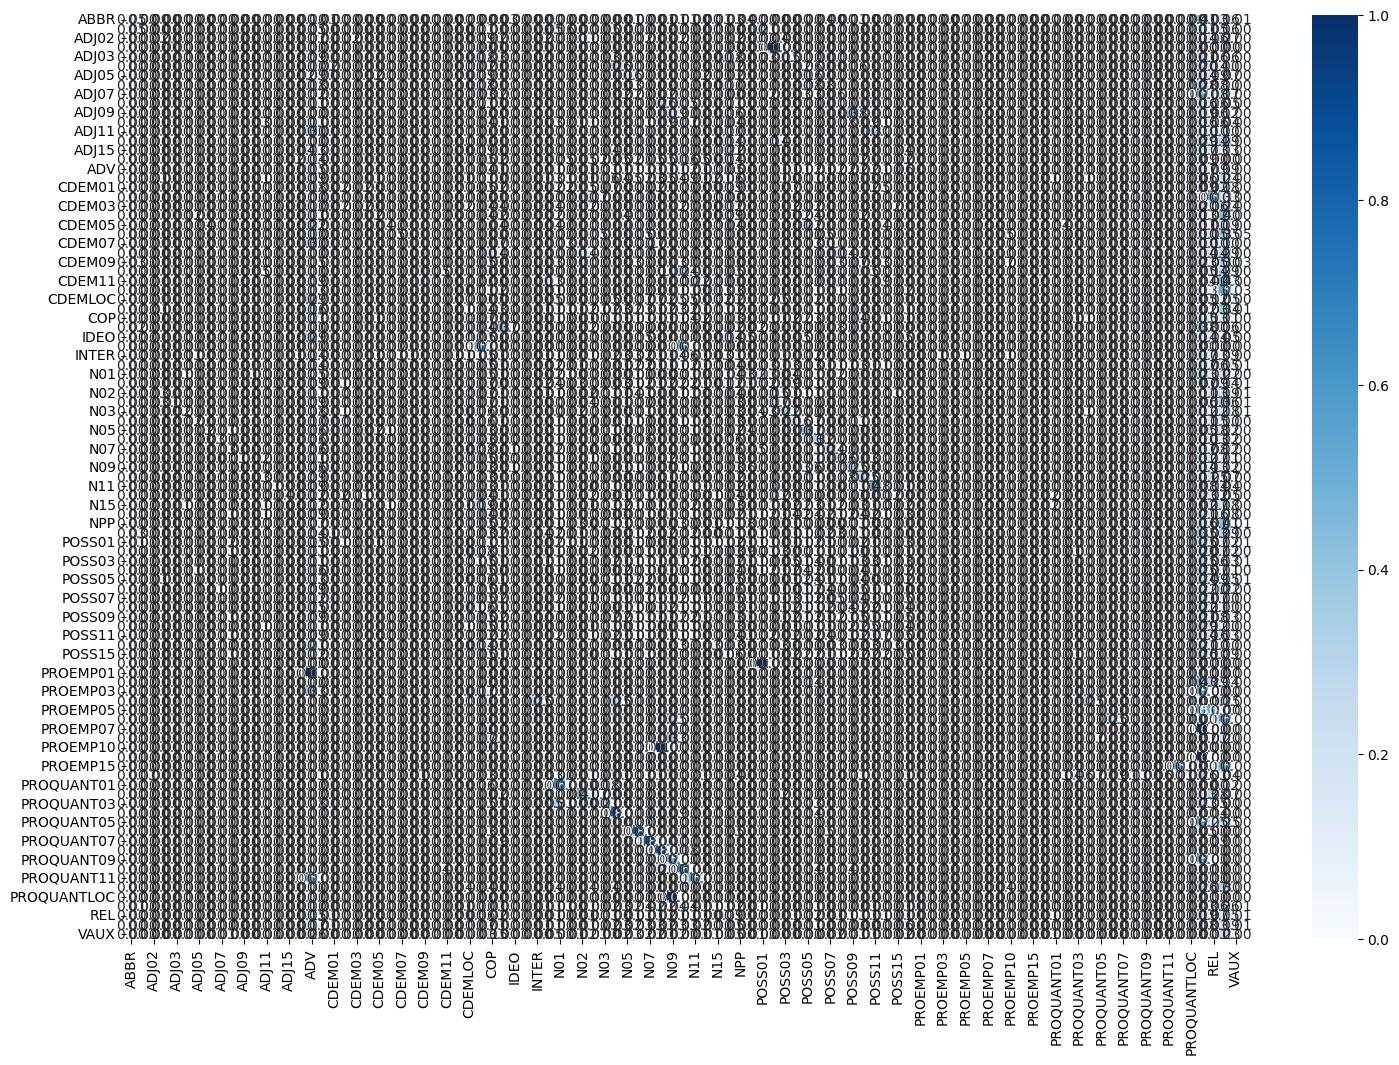

In [12]:
#Model Transition Table.
transition_matrix = model.transmat_
num_hidden_states = transition_matrix.shape[0]
Y_decoded = tag_encoder.classes_
transition_df = pd.DataFrame(transition_matrix, columns=Y_decoded, index=Y_decoded)

print("Transition Matrix:")
print(transition_matrix.shape)
plt.figure(figsize=(18, 12))
sns.heatmap(transition_df, annot=True, fmt=".2f", cmap="Blues")  # Adjust fmt for better display of probabilities
plt.show()

In [13]:
#Emission Table
emission_matrix = model.emissionprob_
emission_matrix.shape

(99, 11809)

In [14]:
#Marking unknown words with unknown word tag (<UNK>) on the test dataset.
test_data.loc[~test_data['Token'].isin(vocabulary), 'Token'] = '<UNK>'

Hiddin Markov Model Testing

In [15]:
#Sample of encoded tokens from test_data.Token (Token to Number).
word_test = list(test_data.Token)
samples = []
for token in word_test:
    word_index = word_indices.get(token, -1)
    samples.append([word_index])

#Number if tokens per sentence.
sentence_lengths = []
count = 0
sentences = list(test_data.Sentence)
for i in range(len(sentences)) :
    if (i > 0) and (sentences[i] == sentences[i - 1]):
        count += 1
    elif i > 0:
        sentence_lengths.append(count)
        count = 1
    else:
        count = 1
sentence_lengths.append(count)

In [ ]:
len(samples), sum(sentence_lengths)

sentence_lengths

In [17]:
#Getting UPOS predictions from the model.
tag_predict = model.predict(samples, sentence_lengths)

ValueError: Expected 2D array, got 1D array instead:
array=[1378   62   60 ... 2783   62   11].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
#Enumerating tags in testing set.
tags_test = list(test_data.UPOS)
tag_test = np.zeros((len(tags_test), ), dtype=int)

for i, tag in enumerate(tags_test):
    tag_test[i] = tag_encoder.transform([tag])[0]

In [ ]:
#Definition of a function that prints model performance results.


def results(y_pred, y_test):
    mlb = MultiLabelBinarizer()
    y_pred_bin = mlb.fit_transform(y_pred)
    y_test_bin = mlb.transform(y_test)

    print("Accuracy: {}".format(metrics.flat_accuracy_score(y_test, y_pred)))
    print("Precision: {}".format(precision_score(y_test_bin, y_pred_bin, average='weighted')))
    print("Recall: {}".format(recall_score(y_test_bin, y_pred_bin, average='weighted')))
    print("F1-Score: {}".format(f1_score(y_test_bin, y_pred_bin, average='weighted')))


In [ ]:
#HMM model results.
print("HMM model results:")

print("Accuracy: {}".format(accuracy_score(tag_test, tag_predict)))
print("Precision: {}".format(precision_score(tag_test, tag_predict, average='weighted')))
print("Recall: {}".format(recall_score(tag_test, tag_predict, average='weighted')))
print("F1-Score: {}".format(f1_score(tag_test, tag_predict, average='weighted')))

# Conditional Random Fields(CRF) Model Section

In [ ]:
# Features for each word in a sentence
def word_features(sentence, i):
    word = sentence[i][0]
    word_morphology = sentence[i][2]
    word_lamme = sentence[i][3]
    features = {
      'word': word,
      'morphology': word_morphology,
      'lamme': word_lamme,

      #Booleans
      'is_first': i == 0,
      'is_last': i == len(sentence) - 1,
      'is_capitalized': word[0].upper() == word[0],
      'is_all_caps': word.upper() == word,
      'is_all_lower': word.lower() == word,

      #prefix of the word
      'prefix-1': word[0],
      'prefix-2': word[:2],
      'prefix-3': word[:3],

      #suffix of the word
      'suffix-1': word[-1],
      'suffix-2': word[-2:],
      'suffix-3': word[-3:],

      #Previous word
      'prev_word': '' if i == 0 else sentence[i-1][0],

      #Next word
      'next_word': '' if i == len(sentence)-1 else sentence[i+1][0],

      'has_hyphen': '-' in word,
      'is_numeric': word.isdigit(),
      'capitals_inside': word[1:].lower() != word[1:]
    }
    return features

In [ ]:
#Sentence Formatting Dataset.
tagged_sent = []
for _, group in df.groupby('Sentence'):
    sent_tokens = []
    for _, row in group.iterrows():
        sent_tokens.append((row['Token'], row['UPOS'], row['Morph_Analysis'], row['Lemma']))
    tagged_sent.append(sent_tokens)

In [ ]:
#Getting for each sentence in the data set.
X_data = []
y_data = []
for sentence in tagged_sent:
    feature_sentence = []
    tag_sentence = []
    for i in range(len(sentence)):
        feature_sentence.append(word_features(sentence, i))
        tag_sentence.append(sentence[i][1])
    X_data.append(feature_sentence)
    y_data.append(tag_sentence)

In [ ]:
#Spliting the data into training and testing datasets.
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=101)

In [ ]:
#Initializing the CRF Model and training.
crf = sklearn_crfsuite.CRF(
	algorithm='lbfgs',
	c1=0.1,
	c2=0.1,
	max_iterations=100,
	all_possible_transitions=True
)
crf.fit(X_train, y_train)
y_pred = crf.predict(X_test)

In [ ]:
#CRF model results.
print("CRF model results")

mlb = MultiLabelBinarizer()
y_pred_bin = mlb.fit_transform(y_pred)
y_test_bin = mlb.transform(y_test)

print("Accuracy: {}".format(metrics.flat_accuracy_score(y_test_bin, y_pred_bin)))
print("Precision: {}".format(precision_score(y_test_bin, y_pred_bin, average='weighted')))
print("Recall: {}".format(recall_score(y_test_bin, y_pred_bin, average='weighted')))
print("F1-Score: {}".format(f1_score(y_test_bin, y_pred_bin, average='weighted')))